## Traveling Salesman Problem

Objective: find shortest path between nodes while minimizing travel costs and reaching each destination once and once only


<img src="https://crescointl.com/wp-content/uploads/2021/03/traveling_salesman-Medium-930x620.png" width="650"/>

Constraints:

<img src="https://miro.medium.com/max/1400/1*Dmw4GsdDOcoC00xQQwhldQ.png" width="650"/>


Subtour constraint is most difficult of all: including all possible combinations blows up memory, so will need to tackle this issue in an iterative approach: if a subtour is found, include its and only its parameters as constraints and hope that the next iteration does not include any subtours. Repeat until no subtours are part of the optimal route. If there are n destiations then there are **2^n - 2** subtours to account for...

In [1]:
for n in range(5, 50, 5):
    print('For', n, 'destinations the # of subtour contraints are:', 2**n - 2)

For 5 destinations the # of subtour contraints are: 30
For 10 destinations the # of subtour contraints are: 1022
For 15 destinations the # of subtour contraints are: 32766
For 20 destinations the # of subtour contraints are: 1048574
For 25 destinations the # of subtour contraints are: 33554430
For 30 destinations the # of subtour contraints are: 1073741822
For 35 destinations the # of subtour contraints are: 34359738366
For 40 destinations the # of subtour contraints are: 1099511627774
For 45 destinations the # of subtour contraints are: 35184372088830


In [2]:
import pandas as pd
import numpy as np
import math

import pulp

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'user_agent', timeout = 10)

from data.countries_capitals import countries

from scipy.spatial import distance_matrix

import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def geocode_location(location):

    geocoded = geolocator.geocode(location)
    _lat = geocoded.latitude
    _lon = geocoded.longitude

    return (_lat, _lon)

def plot_destinations_map():

    geo_data['size'] = 10

    fig = px.scatter_mapbox(geo_data, lat = 'latitude', lon = 'longitude', hover_data=['destination'],
                                title = 'Érintendő városok elhelyezkedése', 
                                center = {"lat": geo_data['latitude'].mean(), "lon": geo_data['longitude'].mean()},
                                zoom = 3, size_max = 12, size = 'size',
                                mapbox_style = 'carto-positron', height = 650, width = 950)
    fig.show()

    geo_data.drop('size', 1, inplace = True)

def plot_fig(loc):

    plt.figure(figsize=(16, 12))
    for i,row in loc.iterrows():
        if i==0:
            plt.scatter(row["longitude"],row["latitude"],c='r')
            plt.text(row["longitude"]+0.1, row["latitude"]+0.1, destinations[0].split(',')[0], fontsize = 9)
        else:
            plt.scatter(row["longitude"], row["latitude"], c='black')
            plt.text(row["longitude"] + 0.1, row["latitude"] + 0.1, loc.loc[i]['destination'].split(',')[0], fontsize = 9)
        plt.xlim(loc['longitude'].min() - 1.5, loc['longitude'].max() + 1.5)
        plt.ylim(loc['latitude'].min() - 1, loc['latitude'].max() + 1)
        plt.title('Destination dots - map for checking connectivity')


def get_plan(r0):
    r=r0.copy()
    route = []
    while len(r) != 0:
        plan = [r[0]]
        del (r[0])
        l = 0
        while len(plan) > l:
            l = len(plan)
            for i, j in enumerate(r):
                if plan[-1][1] == j[0]:
                    plan.append(j)
                    del (r[i])
        route.append(plan)
    return(route)

### 1. Set cities that we want to visit

In [24]:
# destinations = ['Budapest, Hungary', 'Vienna, Austria', 'Prague, Czech Republic', 'Zurich, Switzerland', 
#                 'Amsterdam, Netherlands', 'Berlin, Germany', 'Paris, France', 'Nice, France',
#                 'Venezia, Italy', 'Firenze, Italy', 'Napoli, Italy', 'Palermo, Italy', 'Lyon, France', 
#                 'Barcelona, Spain', 'Madrid, Spain', 'Lisbon, Portugal', 'Andorra']

# destinations = ['Venezia, Italy', 'Milano, Italy', 'Genova, Italy', 'Bologna, Italy', 
#                 'Firenze, Italy', 'Pisa, Italy', 'Roma, Italy', 'Napoli, Italy',
#                 'Palermo, Italy', 'Alghero, Italy', 'Bari, Italy', 'Catanzaro, Italy', 'Torino, Italy', 
#                 'Parma, Italy', 'Rimini, Italy', 'La Spezia, Italy', 'Messina, Italy', 'Lecce, Italy',
#                 "L'Aquila, Italy", 'Perugia, Italy', 'Vieste, Italy']

# destinations = ['Budapest, Hungary', 'Salgotarjan', 'Miskolc, Hungary', 'Szolnok, Hungary', 
#                 'Nyiregyhaza, Hungary', 'Debrecen, Hungary', 'Bekescsaba, Hungary', 'Szeged, Hungary',
#                 'Kecskemet, Hungary', 'Pecs, Hungary', 'Szekszard, Hungary', 'Kaposvar, Hungary', 'Szekesfehervar, Hungary', 
#                 'Zalaegerszeg, Hungary', 'Szombathely, Hungary', 'Veszprem, Hungary', 'Gyor, Hungary', 'Tatabanya, Hungary']

destinations = [x['capital'] + ', ' + x['name'] for x in countries if x['continent'] == 'Europe']

In [25]:
# set([x['continent'] for x in countries])

In [26]:
destinations[:5]

['Andorra la Vella, Andorra',
 'Tirana, Albania',
 'Vienna, Austria',
 'Brussels, Belgium',
 'Sofia, Bulgaria']

### 2. Get coordinates for cities, calculate distance matrix
This will need to be optimized (distance ~ travel cost, so minimizing traveled km is also minimizing costs - not always, but good enough for us)

In [27]:
lat = []
lon = []
found = []
not_found = []

for destination in destinations:
    try:
        _lat, _lon = geocode_location(destination)
        lat.append(_lat)
        lon.append(_lon)
        found.append(destination)

    except AttributeError:
        not_found.append(destination)


In [28]:
print(len(not_found), 'destinations were not geocoded, check them manually')
print(not_found)

0 destinations were not geocoded, check them manually
[]


In [29]:
len(found) == len(destinations)

True

In [30]:
geo_data = pd.DataFrame([destinations, lat, lon]).T.rename(columns = {0 : 'destination', 1 : 'latitude', 2 : 'longitude'})
geo_data.head(3)

,destination,latitude,longitude
0,"Andorra la Vella, Andorra",42.506939,1.521247
1,"Tirana, Albania",41.330514,19.825563
2,"Vienna, Austria",48.208354,16.372504


Check results on map

In [31]:
plot_destinations_map()

Distance matrix

In [32]:
distances = pd.DataFrame(distance_matrix(geo_data[['latitude', 'longitude']], geo_data[['latitude', 'longitude']]),
                         columns = geo_data['destination'],
                         index = geo_data['destination'])

### 3. Create LP problem, set objective and constraints

First, not setting any subtour constraints - let's see what happens

In [33]:
prob = pulp.LpProblem('Optimize traveling route', pulp.const.LpMinimize)

In [34]:
dist_dict = dict(((a, b), distances[a][b]) for a in geo_data.destination for b in geo_data.destination if a != b)
_variables = pulp.LpVariable.dicts('city_pair', dist_dict, 0, 1, pulp.const.LpBinary)

prob += pulp.lpSum([dist_dict[i] * _variables[i] for i in _variables])

In [35]:
for i in destinations:

    # max 1 outgoing route
    prob += pulp.lpSum([_variables[(i, j)] for j in destinations if (i, j) in _variables]) == 1, 'outgoing from ' + i

    # max 1 incoming route
    prob += pulp.lpSum([_variables[(j, i)] for j in destinations if (j, i) in _variables]) == 1, 'incoming to ' + i

In [36]:
# print(prob)

In [37]:
%%time

status = prob.solve()
print('Status:', pulp.LpStatus[status])

OPTIMUM = pulp.value(prob.objective)
print('Optimal traveled distance:', OPTIMUM)

Status: Optimal
Optimal traveled distance: 188.08466785791978
Wall time: 241 ms


In [38]:
# for variable in prob.variables():
#     if variable.varValue == 1:
#         print("{} = {}".format(variable.name, variable.varValue))

optimal_routes = [key for key in _variables if _variables[key].varValue == 1]
# optimal_routes

#### Detect subtours, connectivity of destinations

Before optimizing route

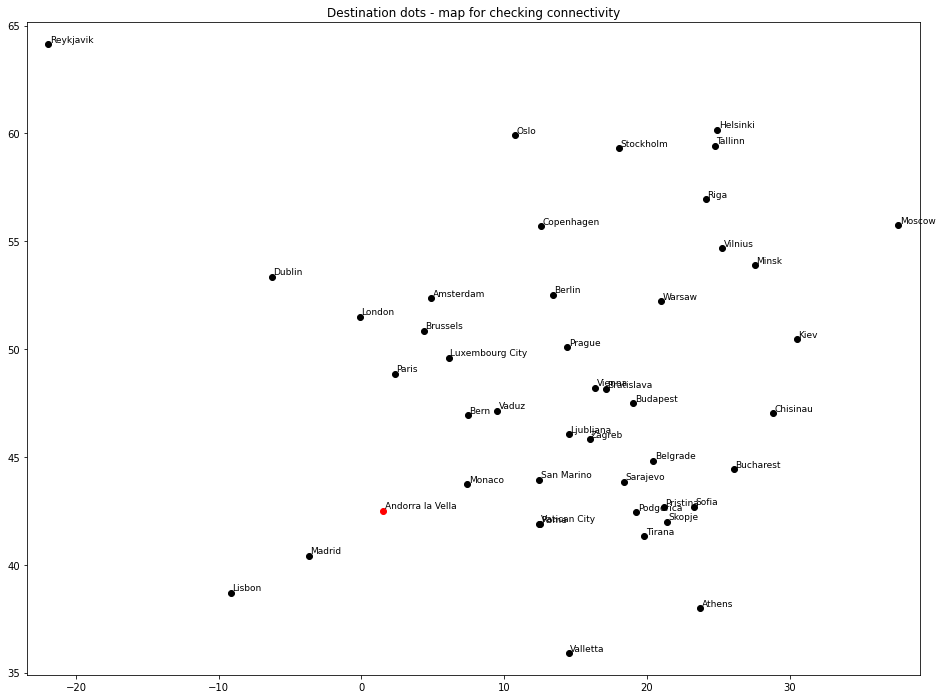

In [39]:
plot_fig(geo_data)

After running first iteration of optimization

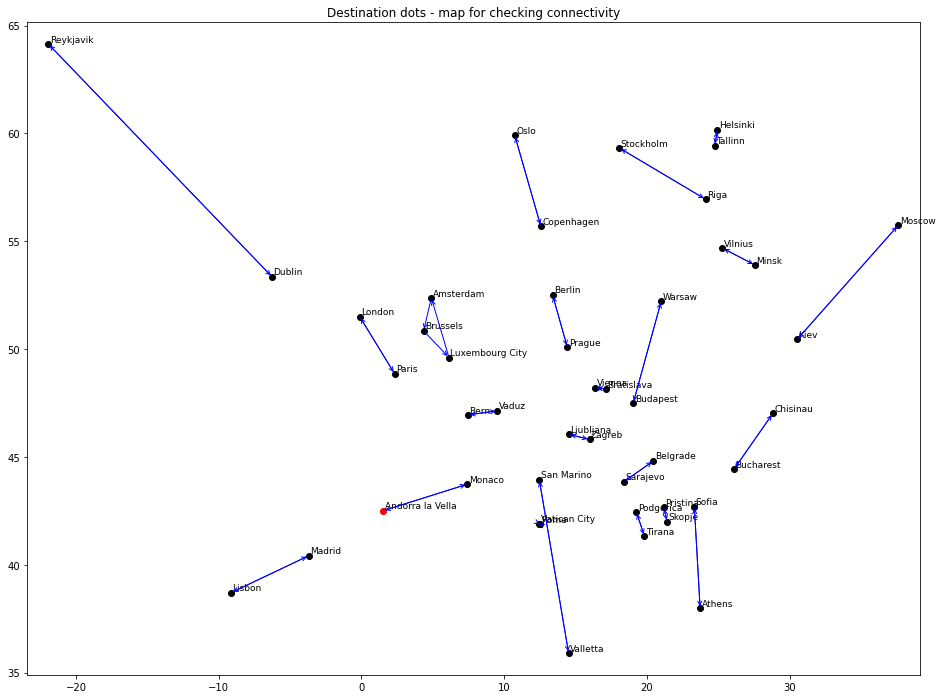

In [40]:
plot_fig(geo_data)

arrowprops = {'arrowstyle' : '->', 'connectionstyle' : 'arc3', 'edgecolor': 'blue'}

for i, j in optimal_routes:
    plt.annotate('', xy=[geo_data.set_index('destination').loc[j]['longitude'], geo_data.set_index('destination').loc[j]['latitude']],
                 xytext=[geo_data.set_index('destination').loc[i]['longitude'], geo_data.set_index('destination').loc[i]['latitude']],
                 arrowprops = arrowprops)

**Clearly there are subtours** - to fix them we can either choose the iterative approach, or, if we have a small destination count, by setting the constraints initially

### 4. Set subtour constraints upfront iteratively

In [41]:
%%time

prob = pulp.LpProblem('Optimize traveling route', pulp.const.LpMinimize)

prob += pulp.lpSum([dist_dict[i] * _variables[i] for i in _variables])

for i in destinations:
    # max 1 outgoing route
    prob += pulp.lpSum([_variables[(i, j)] for j in destinations if (i, j) in _variables]) == 1, 'outgoing from ' + i

    # max 1 incoming route
    prob += pulp.lpSum([_variables[(j, i)] for j in destinations if (j, i) in _variables]) == 1, 'incoming to ' + i

status = prob.solve()

optimal_routes = [key for key in _variables if _variables[key].varValue == 1]
plan = get_plan(optimal_routes)

# until plan is not just 1 long route, LP model will have to reoptimize considering the subtours

subtour = []
while len(plan) != 1:

    for i in range(len(plan)):
        prob += pulp.lpSum(_variables[plan[i][j][0], plan[i][j][1]] for j in range(len(plan[i]))) <= len(plan[i]) - 1
    status = prob.solve()
    route = [key for key in _variables if _variables[key].varValue == 1]
    plan = get_plan(route)
    subtour.append(len(plan))


Wall time: 29 s


In [26]:
# save model as it took forever to optimize
prob.to_json('models/europe_tour.json')

Check results

In [42]:
print("Number of iterations to reach optimum: ",len(subtour))
print("Number of subtours at each iteration", subtour)

OPTIMUM = pulp.value(prob.objective)
print('Optimal traveled distance:', OPTIMUM)

Number of iterations to reach optimum:  16
Number of subtours at each iteration [5, 6, 2, 2, 2, 2, 3, 3, 4, 2, 3, 2, 2, 3, 3, 1]
Optimal traveled distance: 211.93752845804718


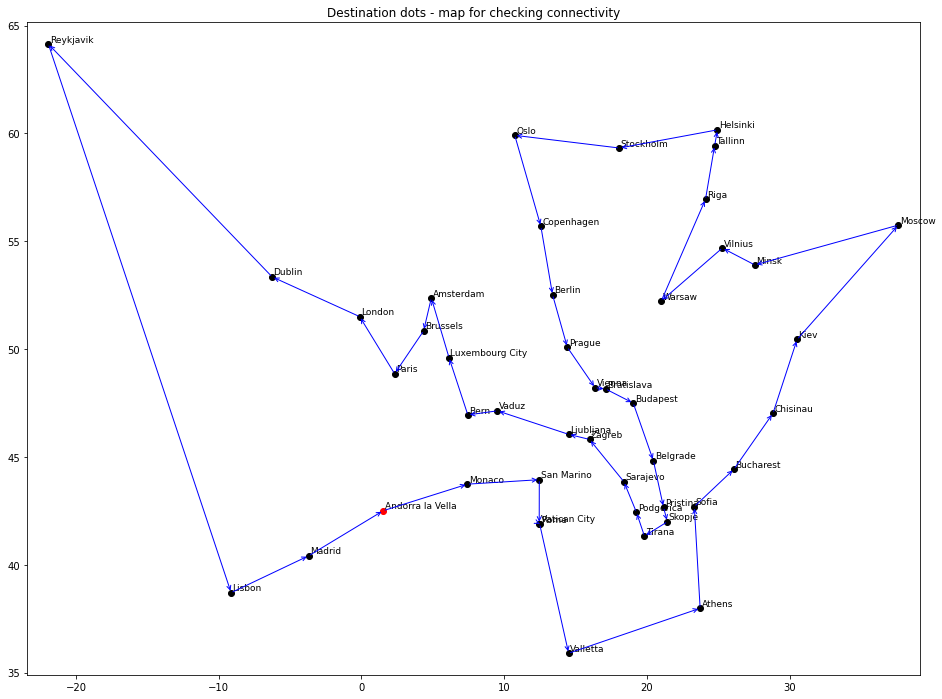

In [43]:
optimal_routes = [key for key in _variables if _variables[key].varValue == 1]

plot_fig(geo_data)

arrowprops = {'arrowstyle' : '->', 'connectionstyle' : 'arc3', 'edgecolor': 'blue'}

for i, j in optimal_routes:
    plt.annotate('', xy=[geo_data.set_index('destination').loc[j]['longitude'], geo_data.set_index('destination').loc[j]['latitude']],
                 xytext=[geo_data.set_index('destination').loc[i]['longitude'], geo_data.set_index('destination').loc[i]['latitude']],
                 arrowprops = arrowprops)

In [23]:
get_plan(optimal_routes)

[[('Venezia, Italy', 'Bologna, Italy'),
  ('Bologna, Italy', 'Firenze, Italy'),
  ('Firenze, Italy', 'Pisa, Italy'),
  ('Pisa, Italy', 'Parma, Italy'),
  ('Parma, Italy', 'La Spezia, Italy'),
  ('La Spezia, Italy', 'Genova, Italy'),
  ('Genova, Italy', 'Milano, Italy'),
  ('Milano, Italy', 'Torino, Italy'),
  ('Torino, Italy', 'Alghero, Italy'),
  ('Alghero, Italy', 'Palermo, Italy'),
  ('Palermo, Italy', 'Messina, Italy'),
  ('Messina, Italy', 'Catanzaro, Italy'),
  ('Catanzaro, Italy', 'Lecce, Italy'),
  ('Lecce, Italy', 'Bari, Italy'),
  ('Bari, Italy', 'Vieste, Italy'),
  ('Vieste, Italy', 'Napoli, Italy'),
  ('Napoli, Italy', "L'Aquila, Italy"),
  ("L'Aquila, Italy", 'Roma, Italy'),
  ('Roma, Italy', 'Perugia, Italy'),
  ('Perugia, Italy', 'Rimini, Italy'),
  ('Rimini, Italy', 'Venezia, Italy')]]

In [ ]:
# print(prob)